##**Disclaimer**
These are the materials I used for this project:\
**[1]Pavia University Deep Learning**

`06_Attention_and_Transformers_in_BERT.ipynb`\
Multi Head Attention, Encoder Block, Bert Embeddings, Bert

**[2]Pavia University Machine Learning**

`English_to_italian_automatic_translation.ipynb`\
Dataset([Tatoeba Project](https://www.manythings.org/anki/)).For applying this dataset into Bert and GPT2, I removed `<sos>` token and `<eos>` token.\
In transformer, Tokenizer automatically add these token.

**[3]Hugging face**

Tokenizer `bert-base-cased` (English), MarianTokenizer `Helsinki-NLP/opus-mt-en-it`(Italian)

**[4]BLEU(Bilingual Evaluation Understudy) score**

this metrics is 0-1 scoring depend on the similarity of Source Language and Target Language.\
nltk.translate.bleu_score `sentence_bleu, SmoothingFunction`

**[5]Pytorch**

In pytorch, Weight of Neural Networks are automatically initialized: I did not use any other configuration but with default settings.


**My Implementation**:

- `Cross Head Attention` (Modify `Multi head Attention` (Self Attention))
- `BERT2GPT` (This idea is common, but I reimplemented wheel)
- `Translation Dataset`
- `Learning Phase`, `Inference Phase`
- `Bert Embedding Visualization` (Based on my Word2Vec Visualization implementation)


Bert Implementation - This was implemented by Naoya Kumakura with refering to [1]

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import transformers
class MultiHeadAttention(nn.Module):
    """
    - Query, Key, Value
    - Scaled Dot Product Attention: softmax(QK^T / sqrt(d_k))V
    """
    def __init__(self, d_model, num_heads, dropout=0.1):
        super().__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"

        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads
        self.dropout = torch.nn.Dropout(dropout)

        # Q, K, V linear Conversion
        self.query = torch.nn.Linear(d_model, d_model)
        self.key = torch.nn.Linear(d_model, d_model)
        self.value = torch.nn.Linear(d_model, d_model)

        self.out_proj = torch.nn.Linear(d_model, d_model)

    def forward(self, x, mask=None):
        batch_size, seq_len, d_model = x.shape

        # step1: Q, K, V
        query = self.query(x)  # (batch, seq_len, d_model)
        key = self.key(x)      # (batch, seq_len, d_model)
        value = self.value(x)  # (batch, seq_len, d_model)

        # step2: Multi-Head
        query = query.view(batch_size, seq_len, self.num_heads, self.head_dim)
        key = key.view(batch_size, seq_len, self.num_heads, self.head_dim)
        value = value.view(batch_size, seq_len, self.num_heads, self.head_dim)

        # step3: Change Dimention for Calclate Efficiently
        query = query.permute(0, 2, 1, 3)  # (batch, num_heads, seq_len, head_dim)
        key = key.permute(0, 2, 1, 3)
        value = value.permute(0, 2, 1, 3)

        # step4: Scaled Dot-Product Attention
        # scores = Q @ K^T / sqrt(d_k)
        scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(self.head_dim)

        # step5: masking
        if mask is not None:
            scores = scores + mask

        # step6: Softmax + Dropout
        weights = F.softmax(scores, dim=-1)  # (batch, num_heads, seq_len, seq_len)
        weights = self.dropout(weights)
        # step7: multiply with Value
        context = torch.matmul(weights, value)
        # step8: Restore the original shape of tensor
        context = context.permute(0, 2, 1, 3)
        # → (batch, seq_len, d_model)
        context = context.contiguous().view(batch_size, seq_len, self.num_heads * self.head_dim)

        # Step9: Final Linear Conversion
        return self.out_proj(context)  # 修正: output_linear → out_proj

class PositionwiseFeedForward(nn.Module):
    """
    Property:
    - 2 layer Neural Network
    - 中間層では次元を拡張（通常4倍）Based on the paper, Hidden Layer has 4 times bigger dimention
    - GELU is used (It has Effect of Regularization to some Extent)
    - Drop out (Regularization)
    """
    def __init__(self, d_model, d_ff, dropout=0.1):
        super().__init__()
        self.linear1 = nn.Linear(d_model, d_ff)  # 入力次元 → 中間次元
        self.linear2 = nn.Linear(d_ff, d_model)  # 中間次元
        self.dropout = nn.Dropout(dropout)
        self.gelu = nn.GELU()

    def forward(self, x):
        x = self.linear1(x)
        x = self.gelu(x)
        x = self.dropout(x)
        x = self.linear2(x)
        x = self.dropout(x)
        return x

class EncoderBlock(nn.Module):
    """
    - Multi-Head Attention + Residual Connection + Layer Norm
    - Feed Forward + Residual Connection + Layer Norm
    - Which is better??: Pre-LN vs Post-LN - Pre-LN
    """
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()
        self.attention = MultiHeadAttention(d_model,num_heads)
        self.ffn = PositionwiseFeedForward(d_model,d_ff)

        self.layer_norm1 = nn.LayerNorm(normalized_shape=d_model, eps=1e-6)
        self.layer_norm2 = nn.LayerNorm(normalized_shape=d_model, eps=1e-6)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        #Attention block
        #TODO implement transformer block
        residual = x
        #print("Took Residual...",x.shape)
        x = self.layer_norm1(x)
        #print("calculating layer norm...",x.shape)
        x = self.dropout(self.attention(x,mask))
        #print("calculating Attention...",x.shape)
        x = x + residual
        #print("calculating Residual Connection...",x.shape)
        #ffnn
        residual = x
        x = self.layer_norm2(x)
        #print("calculating layer norm...",x.shape)
        x = self.dropout(self.ffn(x))
        #print("calculating ffn...",x.shape)
        x = x + residual
        return x


class BertEmbeddings(nn.Module):
    """
    - Token Embeddings (Vocabsize × d_model)
    - Position Embeddings (Maximum Sequence length × d_model)
    - Segment Embeddings (2 × d_model, NSP Task)
    - Add three types of embedding, LayerNorm and Dropout
    """
    def __init__(self, vocab_size, d_model, max_seq_len=512, dropout=0.1):
        super().__init__()
        # TODO: 3種類の埋め込みを実装
        self.d_model = d_model
        self.token = torch.nn.Embedding(vocab_size, d_model, padding_idx=0)
        self.position = torch.nn.Embedding(max_seq_len, d_model)
        self.segment = torch.nn.Embedding(2, d_model)  # 2つのセグメント（0と1）
        self.layer_norm = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        #Embedding: Lookup table that keep meaning vector of words
    def forward(self, input_ids, token_type_ids=None):
        # TODO: 埋め込みの計算を実装
        batch_size, seq_len = input_ids.shape
        # Step 1: Token Embeddings
        token_embeddings = self.token(input_ids)
        # Step 2: Position Embeddings
        position_ids = torch.arange(seq_len, device=input_ids.device).unsqueeze(0)
        position_ids = position_ids.expand(batch_size, -1)  # 🔧 バッチ次元を拡張
        position_embeddings = self.position(position_ids)
        # Step 3: Segment Embeddings
        if token_type_ids is None:
            token_type_ids = torch.zeros_like(input_ids)  # 全て0（単一文）
        segment_embeddings = self.segment(token_type_ids)  # (batch, seq_len, d_model)
        embeddings = token_embeddings + position_embeddings + segment_embeddings
        embeddings = self.dropout(self.layer_norm(embeddings))

        return embeddings

class Bert(nn.Module):
    def __init__(self, vocab_size, d_model=768, num_layers=12, num_heads=12, d_ff=3072, max_seq_len=512, dropout=0.1):
        super().__init__()
        self.d_model = d_model
        self.num_layers = num_layers
        self.heads = num_heads
        # paper noted 4*d_model size for ff
        self.feed_forward_hidden = d_model * 4
        # embedding for BERT, sum of positional, segment, token embeddings
        self.embedding = BertEmbeddings(vocab_size, d_model, max_seq_len, dropout)

        self.encoder_blocks = torch.nn.ModuleList(
            [EncoderBlock(d_model, num_heads, d_model * 4, dropout) for _ in range(num_layers)])

    def forward(self, input_ids, attention_mask=None, token_type_ids=None):
        # Implement All BERT forward pass
        if attention_mask is None:
            attention_mask = (input_ids != 0).float()
        if attention_mask.dim() == 2:
            # (batch, seq_len) → (batch, 1, 1, seq_len)
            extended_attention_mask = attention_mask.unsqueeze(1).unsqueeze(2)
            # print("squeeze is required")
        elif attention_mask.dim() == 4:
            # If it has correct shape, just use it
            extended_attention_mask = attention_mask
            # print("squeeze is not required")
        else:
             raise ValueError(f"Attention mask should be 2D or 4D, but got {attention_mask.dim()}D")

        # Convert attention mask (0) into -1e9（to make it 0 in Softmax）
        extended_attention_mask = (1.0 - extended_attention_mask) * -1e9


        # embedding the indexed sequence to sequence of vectors
        x = self.embedding(input_ids, token_type_ids)
        # running over multiple transformer blocks
        for encoder in self.encoder_blocks:
            x = encoder.forward(x, extended_attention_mask)
        return x


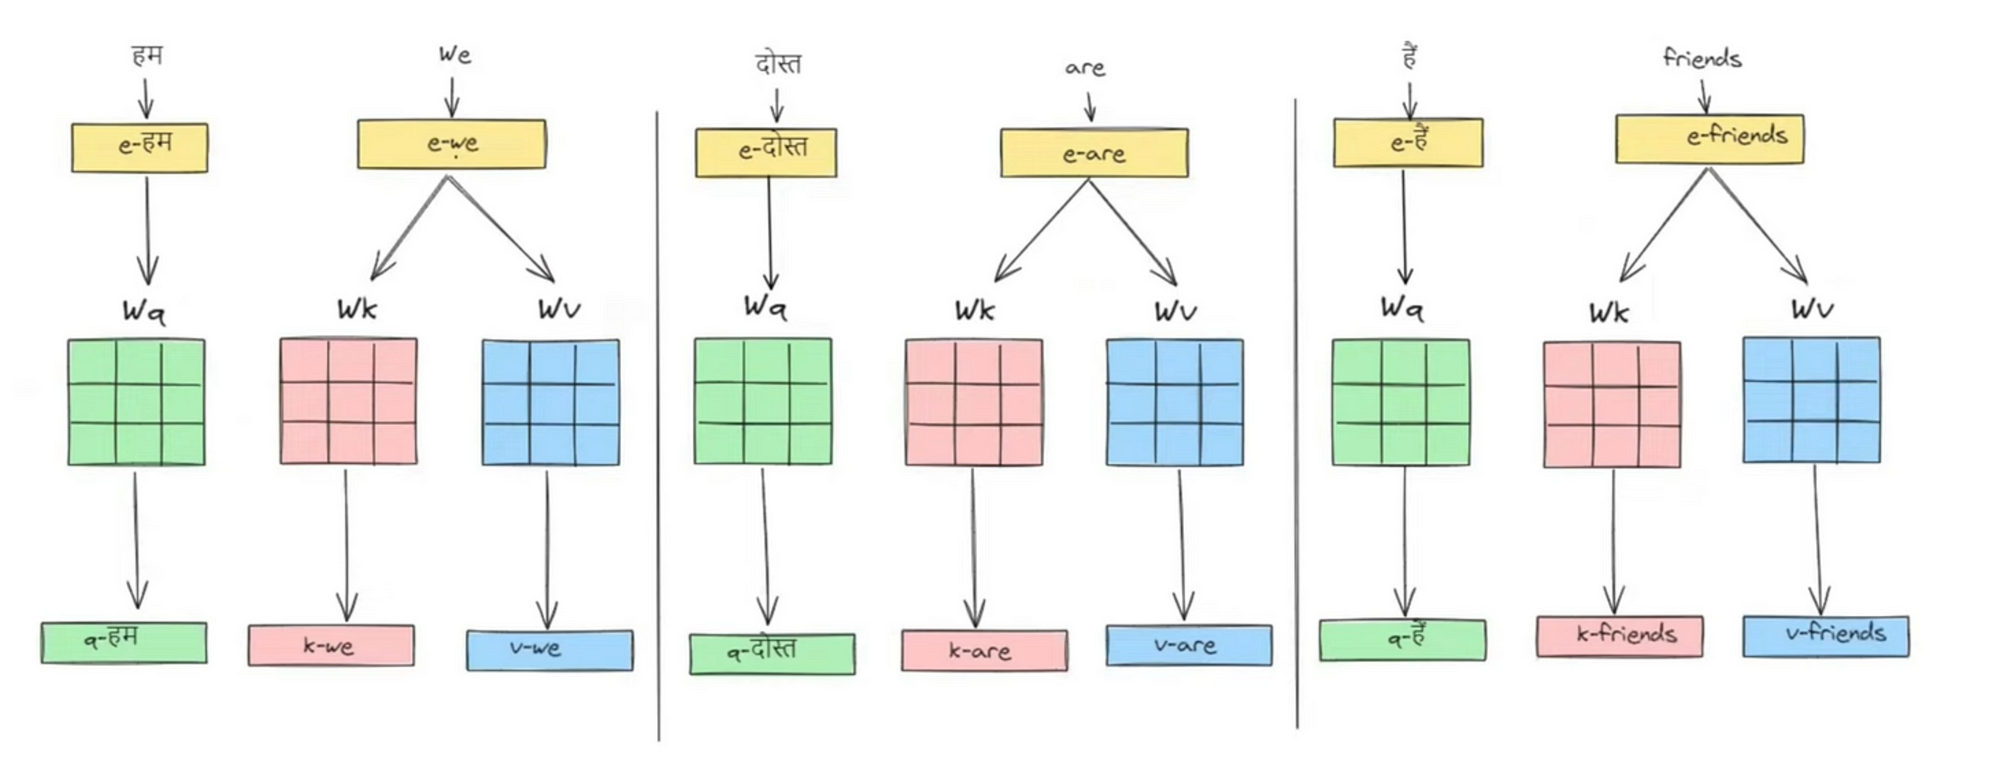
https://www.google.com/url?sa=i&url=https%3A%2F%2Fmedium.com%2F%40sachinsoni600517%2Fcross-attention-in-transformer-f37ce7129d78&psig=AOvVaw1GTR9Lb7aRDartRoVIExQr&ust=1751940719808000&source=images&cd=vfe&opi=89978449&ved=0CBcQjhxqFwoTCIjQxvTVqY4DFQAAAAAdAAAAABAJ

In [2]:
class CrossAttention(nn.Module):
    """
    this module is implemented with modifying MultiHeadAttention.
    Query: English
    Key, Value: Italian
    You can see the difference in forward input
    """
    def __init__(self, d_model, num_heads, dropout=0.1):
        super().__init__() # initialization
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"

        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads  # dimention of each head
        self.dropout = torch.nn.Dropout(dropout)

        # Linear transformation of Q, K, V
        self.query = torch.nn.Linear(d_model, d_model)
        self.key = torch.nn.Linear(d_model, d_model)
        self.value = torch.nn.Linear(d_model, d_model)

        # Final Linear transformation
        self.out_proj = torch.nn.Linear(d_model, d_model)

    def forward(self, query_input, key_value_input, mask=None): # here is the difference compared to Self Attention:)
        batch_size, q_len, _ = query_input.shape
        _, kv_len, _ = key_value_input.shape
        # Step1: Calculate Q, K, V from query, key, value(query:Eng, key value:Italian)
        query = self.query(query_input)  # (batch, seq_len, d_model)
        key = self.key(key_value_input)      # (batch, seq_len, d_model)
        value = self.value(key_value_input)  # (batch, seq_len, d_model)

        # Step2: Change dimention for Multi-Head Attention
        query = query.view(batch_size, q_len, self.num_heads, self.head_dim)
        key = key.view(batch_size, kv_len, self.num_heads, self.head_dim)
        value = value.view(batch_size, kv_len, self.num_heads, self.head_dim)

        query = query.permute(0, 2, 1, 3)  # (batch, num_heads, seq_len, head_dim)
        key = key.permute(0, 2, 1, 3)
        value = value.permute(0, 2, 1, 3)

        # Step4: Scaled Dot-Product Attention
        # scores = Q @ K^T / sqrt(d_k)
        scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(self.head_dim)

        # Step5: Masking
        if mask is not None:
            # mask shape: (batch, 1, 1, seq_len) → scores shape: (batch, num_heads, seq_len, seq_len)
            scores = scores + mask  # add with broadcast

        # Step6: Softmax + Dropout
        weights = F.softmax(scores, dim=-1)  # (batch, num_heads, seq_len, seq_len)
        weights = self.dropout(weights)
        # Step7: Multiplication with Value
        context = torch.matmul(weights, value)
        # Step8: Restore original shape with permute
        context = context.permute(0, 2, 1, 3)
        # → (batch, seq_len, d_model)
        context = context.contiguous().view(batch_size, q_len, self.num_heads * self.head_dim)

        # Step9: Final Linear Transformation
        return self.out_proj(context)

class GPT2DecoderBlockWithCrossAttention(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads, dropout)
        self.cross_attn = CrossAttention(d_model, num_heads, dropout)
        self.ffn = PositionwiseFeedForward(d_model, d_ff, dropout)

        self.ln1 = nn.LayerNorm(d_model)
        self.ln2 = nn.LayerNorm(d_model)
        self.ln3 = nn.LayerNorm(d_model)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x, encoder_output, self_attn_mask=None, cross_attn_mask=None):
        # Self Attention（Causal Attention）
        residual = x
        x = self.ln1(x)
        x = self.self_attn(x, mask=self_attn_mask)
        x = self.dropout(x) + residual

        # Cross Attention
        residual = x
        x = self.ln2(x)
        x = self.cross_attn(x, encoder_output, mask=cross_attn_mask)
        x = self.dropout(x) + residual

        # FFN
        residual = x
        x = self.ln3(x)
        x = self.ffn(x)
        x = self.dropout(x) + residual

        return x

class BERT2GPT(nn.Module):
    def __init__(self, encoder: Bert, decoder_layers=6, d_model=768, num_heads=12, d_ff=3072, vocab_size=50257):
        super().__init__()
        self.encoder = encoder
        self.decoder_embedding = nn.Embedding(vocab_size, d_model)
        self.decoder_blocks = nn.ModuleList([
            GPT2DecoderBlockWithCrossAttention(d_model, num_heads, d_ff) for _ in range(decoder_layers)
        ])
        self.ln_f = nn.LayerNorm(d_model)
        self.output_proj = nn.Linear(d_model, vocab_size, bias=False)

    def forward(self, src_input_ids, tgt_input_ids, src_attention_mask=None, tgt_attention_mask=None):
        # Encode source
        encoder_output = self.encoder(src_input_ids, attention_mask=src_attention_mask)

        # Embed target tokens
        tgt_embeddings = self.decoder_embedding(tgt_input_ids)

        # Prepare causal mask for decoder
        batch_size, tgt_len = tgt_input_ids.size()
        device = tgt_input_ids.device
        causal_mask = torch.tril(torch.ones(tgt_len, tgt_len, device=device)).unsqueeze(0).unsqueeze(1)  # (1, 1, tgt_len, tgt_len)
        causal_mask = (1.0 - causal_mask) * -1e9

        x = tgt_embeddings
        for block in self.decoder_blocks:
            x = block(x, encoder_output, self_attn_mask=causal_mask)

        x = self.ln_f(x)
        logits = self.output_proj(x)
        return logits


In [3]:
#Datasetの作り方
#Execute 1 time
### Suppress useless warnings
import warnings
warnings.filterwarnings("ignore", message="The secret `HF_TOKEN` does not exist")
from collections import defaultdict
from transformers import AutoTokenizer, MarianTokenizer

# Download the files, Execute Once
URL = "https://drive.google.com/file/d/1_npGYZk13fs5hE0kAggiSrmKkqW3OrLT/view?usp=sharing"
!gdown --fuzzy $URL -O- | tar -xz
src_tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")  # English
tgt_tokenizer = MarianTokenizer.from_pretrained("Helsinki-NLP/opus-mt-en-it")

Downloading...
From: https://drive.google.com/uc?id=1_npGYZk13fs5hE0kAggiSrmKkqW3OrLT
To: <_io.BufferedWriter name='<stdout>'>
100% 3.92M/3.92M [00:00<00:00, 8.04MB/s]


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/789k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/814k [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


In [4]:
def load_translation_pairs(eng_path, ita_path):
    with open(eng_path, "r") as f_eng, open(ita_path,"r") as f_ita:
        eng_lines = f_eng.read().replace('<sos>', '').replace('<eos>', '').strip().split("\n")
        ita_lines = f_ita.read().replace('<sos>', '').replace('<eos>', '').strip().split("\n")

    assert len(eng_lines) == len(ita_lines), "行数が一致していません"
    return list(zip(eng_lines, ita_lines))
pairs = load_translation_pairs("text-eng.txt", "text-ita.txt")
print(pairs[:5])

[('hi . ', 'ciao ! '), (' hi . ', ' ciao . '), (' run ! ', ' corri ! '), (' run ! ', ' corra ! '), (' run ! ', ' correte ! ')]


In [5]:
import torch
from torch.utils.data import Dataset, DataLoader

class TranslationDataset(Dataset):
    def __init__(self, pairs, src_tokenizer, tgt_tokenizer, max_length=64):
        self.pairs = pairs
        self.src_tokenizer = src_tokenizer
        self.tgt_tokenizer = tgt_tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        src_text, tgt_text = self.pairs[idx]

        src_enc = self.src_tokenizer(
            src_text,
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )

        tgt_enc = self.tgt_tokenizer(
            tgt_text,
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )

        return {
            "src_input_ids": src_enc["input_ids"].squeeze(0),
            "src_attention_mask": src_enc["attention_mask"].squeeze(0),
            "tgt_input_ids": tgt_enc["input_ids"].squeeze(0),
            "tgt_attention_mask": tgt_enc["attention_mask"].squeeze(0),
        }
dataset = TranslationDataset(pairs, src_tokenizer, tgt_tokenizer, max_length=64)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [6]:
from torch.optim import Adam
MAXLEN=20
src_vocab_size = len(src_tokenizer)
tgt_vocab_size = len(tgt_tokenizer)

encoder = Bert(vocab_size=src_vocab_size,
               d_model=768,
               num_layers=12,
               num_heads=12,
               d_ff=3072,
               max_seq_len=512,
               dropout=0.1
               ) # Instantiate the Bert encoder

model = BERT2GPT(encoder=encoder,
                 vocab_size=tgt_vocab_size,
                 decoder_layers=6,
                 d_model=768,
                 num_heads=12,
                 d_ff=3072,
                 )
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

optimizer = Adam(model.parameters(), lr=5e-5)
pad_token_id = tgt_tokenizer.pad_token_id


cuda


In [ ]:
import torch
import torch.nn as nn
from torch.optim import Adam
from tqdm import tqdm
from google.colab import drive
import os
drive.mount('/content/drive')
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
nltk.download('punkt')
nltk.download('punkt_tab') # Download the missing resource
def save_checkpoint(model, optimizer, epoch, step, path_dir="/content/drive/MyDrive/checkpoints"):
    os.makedirs(path_dir, exist_ok=True)
    filename = f"checkpoint_epoch{epoch}_step{step}.pt"
    path = os.path.join(path_dir, filename)
    torch.save({
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "epoch": epoch,
        "step": step,
    }, path)
def find_latest_checkpoint(path_dir="/content/drive/MyDrive/checkpoints"):
    if not os.path.exists(path_dir):
        return None
    checkpoints = [f for f in os.listdir(path_dir) if f.startswith("checkpoint_epoch")]
    if not checkpoints:
        return None
    # ソートして最新のものを取得
    checkpoints = sorted(checkpoints, key=lambda x: (
        int(x.split("epoch")[1].split("_")[0]),  # epoch番号
        int(x.split("step")[1].split(".")[0])    # step番号
    ))
    return os.path.join(path_dir, checkpoints[-1])

def load_latest_checkpoint(model, optimizer=None, path_dir="/content/drive/MyDrive/checkpoints"):
    path = find_latest_checkpoint(path_dir)
    if path is None:
        print("🟡 チェックポイントが見つかりませんでした。最初から開始します。")
        return 0, 0
    # 修正: map_locationを指定してCPUで読み込む
    checkpoint = torch.load(path, map_location=torch.device('cpu'))
    model.load_state_dict(checkpoint["model_state_dict"])
    if optimizer:
        optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    print(f"✅ 最新のチェックポイントを読み込みました: {path}")
    return checkpoint["epoch"], checkpoint["step"]
"""
def load_checkpoint(model, optimizer, path="checkpoint.pt"):
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    start_epoch = checkpoint["epoch"]
    start_step = checkpoint["step"]
    return start_epoch, start_step
"""
def compute_bleu(reference, prediction):
    ref_tokens = nltk.word_tokenize(reference.lower())
    pred_tokens = nltk.word_tokenize(prediction.lower())
    smoothie = SmoothingFunction().method4
    return sentence_bleu([ref_tokens], pred_tokens, smoothing_function=smoothie)

def train(model, dataloader, optimizer, device, pad_token_id, src_tokenizer, tgt_tokenizer, num_epochs=5, print_every=100):
    start_epoch, start_step = 0, 0
    # 修正: load_latest_checkpoint の path_dir を明示的に指定
    start_epoch, start_step = load_latest_checkpoint(model, optimizer, path_dir="/content/drive/MyDrive/checkpoints")

    print(f"✅ チェックポイントから再開: epoch={start_epoch}, step={start_step}")
    model.train()
    criterion = nn.CrossEntropyLoss(ignore_index=pad_token_id)
    for epoch in range(start_epoch, num_epochs):
        epoch_loss = 0
        # 修正: tqdm の開始位置を調整
        pbar = tqdm(enumerate(dataloader, start=start_step if epoch == start_epoch else 0),
                    total=len(dataloader),
                    initial=start_step if epoch == start_epoch else 0,
                    desc=f"Epoch {epoch+1}/{num_epochs}")

        for step, batch in pbar:
            # 修正: チェックポイント保存のパスを修正
            if step % 1000 == 0 and step != start_step: # 開始時のステップはロード済みのためスキップ
              save_checkpoint(model, optimizer, epoch, step, path_dir="/content/drive/MyDrive/checkpoints")
            if epoch == start_epoch and step < start_step:
              continue
            src_input_ids = batch["src_input_ids"].to(device)
            src_attention_mask = batch["src_attention_mask"].to(device)
            tgt_input_ids = batch["tgt_input_ids"].to(device)

            decoder_input = tgt_input_ids[:, :-1]
            labels = tgt_input_ids[:, 1:]

            logits = model(src_input_ids, decoder_input, src_attention_mask)
            loss = criterion(logits.view(-1, logits.size(-1)), labels.reshape(-1))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            pbar.set_postfix({"Loss": loss.item()})
            # 🌟 時々表示する
            if step % print_every == 0:
                model.eval()
                with torch.no_grad():
                    pred_ids = logits.argmax(-1)
                    for i in range(min(2, src_input_ids.size(0))):  # 最大2件だけ表示
                        src_text = src_tokenizer.decode(batch["src_input_ids"][i], skip_special_tokens=True)
                        tgt_text = tgt_tokenizer.decode(batch["tgt_input_ids"][i], skip_special_tokens=True)
                        pred_text = tgt_tokenizer.decode(pred_ids[i], skip_special_tokens=True)

                        bleu = compute_bleu(tgt_text, pred_text)

                        print("\n[Input]     ", src_text)
                        print("[Target]    ", tgt_text)
                        print("[Predicted] ", pred_text)
                        print("[BLEU]      ", f"{bleu:.4f}")

                model.train()
        # エポック終了時のチェックポイント保存のパスを修正
        save_checkpoint(model, optimizer, epoch, step, path_dir="/content/drive/MyDrive/checkpoints")

def greedy_decode(model, src_input_ids, src_attention_mask, tgt_tokenizer, max_len=50, device='cuda'):
    model.eval()
    batch_size = src_input_ids.size(0)
    decoder_input = torch.full((batch_size, 1), tgt_tokenizer.bos_token_id, dtype=torch.long).to(device)

    with torch.no_grad():
        for _ in range(max_len):
            logits = model(src_input_ids, decoder_input, src_attention_mask)
            next_token = logits[:, -1, :].argmax(-1, keepdim=True)  # (batch, 1)
            decoder_input = torch.cat([decoder_input, next_token], dim=1)

            # すべてEOSなら終了（greedy）
            if (next_token == tgt_tokenizer.eos_token_id).all():
                break

    return decoder_input
train(model=model, dataloader=dataloader, optimizer=optimizer, device=device, pad_token_id=pad_token_id, src_tokenizer=src_tokenizer,tgt_tokenizer=tgt_tokenizer,num_epochs=5)

Mounted at /content/drive


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


✅ 最新のチェックポイントを読み込みました: /content/drive/MyDrive/checkpoints/checkpoint_epoch0_step0.pt
✅ チェックポイントから再開: epoch=0, step=0


Epoch 1/5:   0%|          | 1/10410 [00:01<4:37:02,  1.60s/it, Loss=2.66]


[Input]      i think tom is retired.
[Target]     penso che tom sia in pensione .
[Predicted]  o che tom sia see . . .o .o . .ooooo . .o . . .oo .o .o .oooooo .oooo .ooooo .oooo .oooo
[BLEU]       0.0586

[Input]      do you like spinach?
[Target]     vi piacciono gli spinaci ?
[Predicted]  piaceono le pi ?u ? ? ? ? ? ? ? ?o ?o ?ooo pi pi ? ?o pio ? ?oo piooo ? ?o ? pioo ?o pi pi piooooo pi ?ooo ?o ?
[BLEU]       0.0068


Epoch 1/5:   1%|          | 101/10410 [01:22<2:17:42,  1.25it/s, Loss=2.31]


[Input]      that ' s what tom and mary did.
[Target]     è ciò che hanno fatto tom e mary .
[Predicted]  è toò che toquno ato am a mary  .ooooooooooooooooooooooo .oo .oooooooooooooooo ao a
[BLEU]       0.0246

[Input]      are you a senior high school student?
[Target]     sei uno studente delle superiori ?
[Predicted]  i una se se ae a ?ooooooooooooooo a ao aoooo aoo ao a aoo ao a a ao aoooo a ao ao aoo
[BLEU]       0.0112


Epoch 1/5:   2%|▏         | 201/10410 [02:43<2:18:02,  1.23it/s, Loss=2.33]


[Input]      you make it look so easy.
[Target]     la fai sembrare così facile .
[Predicted]  co co combra co così .le . . .ooo . . co .oo co coo co co . . co co co co coo co co co co co co . coo coo co co co co co co co co co co co co co co co
[BLEU]       0.0075

[Input]      i ' m just happy to talk to somebody.
[Target]     sono semplicemente felice di parlare con qualcuno .
[Predicted]  no andmbraee parfelice di parlare . ltanola . . . . . . . . . . . . . . par . . . . . . . . . . . so . . . . . . . . . . . so . so . . .
[BLEU]       0.0140


Epoch 1/5:   3%|▎         | 301/10410 [04:04<2:16:57,  1.23it/s, Loss=2.19]


[Input]      tom and mary are best friends.
[Target]     tom e mary sono migliori amici .
[Predicted]  m e mary sono pigliorei .ici . .oo . .oooooooooo diooooo diooooo di di di dioo dio dioo di dioo di di dio di dio
[BLEU]       0.0540

[Input]      before he died, he was almost blind.
[Target]     prima di morire , era quasi cieco .
[Predicted]  esto .è no ò . .ooooooooooooooooooooooooooooooooooooooooooooooooooo
[BLEU]       0.0269


Epoch 1/5:   4%|▍         | 401/10410 [05:25<2:16:17,  1.22it/s, Loss=2.26]


[Input]      hey, don ' t worry.
[Target]     ehi , non ti preoccupare .
[Predicted]  cco , non  sioccupate . . . . . . . . . . . . . . . . . . . . . .o . . . . . . . . . o . . . . .o . . . . . . . . . .o . .
[BLEU]       0.0135

[Input]      i can ' t come to the office today.
[Target]     io non posso venire in ufficio oggi .
[Predicted]  non posso farire og grficio oggi . che ogo og og og og og og og non og non non non non og non og non non non non non non non non non non non non non non non non non non non og non non non non non non non non non non non
[BLEU]       0.0165


Epoch 1/5:   5%|▍         | 501/10410 [06:46<2:13:52,  1.23it/s, Loss=2.26]


[Input]      tom turned off the water.
[Target]     tom chiuse l'acqua .
[Predicted]  m ed il'auqua . .ooooooooooo .oo . . .o .o .oooooooo . .oooo . .o . ilo il . il . . ilo il iloo il
[BLEU]       0.0105

[Input]      can you justify the use of violence?
[Target]     riesci a giustificare l'utilizzo della violenza ?
[Predicted]  leice il itoare il'alo ?qu mia ? ? ?oo ?oo ?ooooo ? ?o ? ? ?oo ?oo ?oooo ?oo ? ?o ? ?o ?ooooo ?o
[BLEU]       0.0076


Epoch 1/5:   6%|▌         | 601/10410 [08:07<2:13:24,  1.23it/s, Loss=2.35]


[Input]      why aren ' t you doing anything?
[Target]     perché non state facendo nulla ?
[Predicted]  ché non sta ando nia ? ?aosooosooooooooooooooo . perooooooo  pero per peroo peroo pero a a a pero a a ao a
[BLEU]       0.0138

[Input]      you ' ll never make it.
[Target]     tu non ce la farai mai .
[Predicted]  non mai mai lo . . . . . . .o . . . . . . . . . . . . . . . . . . . . .o . . .o . . . . . . . . . . non . . . . . . . . . . . .
[BLEU]       0.0070


Epoch 1/5:   7%|▋         | 701/10410 [09:28<2:11:52,  1.23it/s, Loss=2.04]


[Input]      i wouldn ' t be able to do that.
[Target]     non sarei capace di farlo .
[Predicted]  hoari inelli di farlo . . . . . . . . . . . . . . . . . . in in . . . . di di . in in in . di di . . . in . in . . . in di di in . di di in in di in in
[BLEU]       0.0221

[Input]      why don ' t you tell tom about it?
[Target]     perché non ne parlate a tom ?
[Predicted]  ché non loilar di tom ? ?oo ? ?ooo ? ? ?o ? ? ? ?o ?o di ? di ? dio di ?oo ?o ? di ? ? di di di ? di ? ? dio ? dio dio di ? di
[BLEU]       0.0143


Epoch 1/5:   8%|▊         | 801/10410 [10:49<2:09:48,  1.23it/s, Loss=1.84]


[Input]      turn right there.
[Target]     volta a destra lì .
[Predicted]  ete g giliaì . . . . . .o . . . . . l . . . . l . . l l l l l l .o l l l l l l l l l l l l l l l l l l l l l l l l l l l l
[BLEU]       0.0054

[Input]      you ' re too particular.
[Target]     lei è troppo esigente .
[Predicted]  è è troppo slia . . . .o . . .o . o . . . .  . .    . . . . .   .     .  .      .    .      .
[BLEU]       0.0227


Epoch 1/5:   9%|▊         | 901/10410 [12:10<2:08:26,  1.23it/s, Loss=2.06]


[Input]      do you remember this?
[Target]     si ricorda questa ?
[Predicted]  etecordate quesa ? ?oao ?o ? ?oooo ques ? ?oo ? ques quesooo ques quest ques queso queso ques ques ques ques ques ques queso ques ques ques queso ques queso ques ques ques ques ques ques ques ques ques ques
[BLEU]       0.0066

[Input]      i know i ' m ready.
[Target]     so di essere pronta .
[Predicted]  che prosere pronta . .ooo .oo . . . . .oo .ooo . .o .ooo .o .o . . . . . . .o .oooo . . . .o . . . . .oo
[BLEU]       0.0183


Epoch 1/5:  10%|▉         | 1001/10410 [13:49<16:54:23,  6.47s/it, Loss=1.98]


[Input]      i have the same dictionary as your brother.
[Target]     io ho lo stesso dizionario di tuo fratello .
[Predicted]  ho il stesso il soione il tua iltello . .o .o .oo . . .ooooo .o .o .o .o .o . .o .oo .ooo ilo . ilo ilo il al ilo
[BLEU]       0.0119

[Input]      i was barefoot.
[Target]     ero a piedi nudi .
[Predicted]  ero unbbùi .ean . .o .o .o . . .o . . . . . . . .oo . .o . . . .o .  . . . . .  . . . . . . . . . . . . . .    .
[BLEU]       0.0079


Epoch 1/5:  11%|█         | 1101/10410 [15:11<2:04:54,  1.24it/s, Loss=1.8]


[Input]      i love baseball.
[Target]     io amo il baseball .
[Predicted]  amo il ciball . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
[BLEU]       0.0121

[Input]      i can talk about anything with my best friend.
[Target]     io posso parlare di qualsiasi cosa con la mia migliore amica .
[Predicted]  so parlare con lciasi sa   mia pargli  .ico . .o .ooooooooooo . . . . .oooooooo .ooo . .ooo . .o
[BLEU]       0.0177


Epoch 1/5:  12%|█▏        | 1201/10410 [16:33<2:06:09,  1.22it/s, Loss=1.63]


[Input]      ask tom to help.
[Target]     chieda a tom di aiutare .
[Predicted]  eda a tom a aiuutare . .ooooooo ao a . . ao aoo . a a a aoo a a a a a a a a a a a a a a a a a a a a a a a a a a
[BLEU]       0.0160

[Input]      you ' re a child.
[Target]     tu sei una bambina .
[Predicted]  sei una bambina . . .o . . . . . . . .o . . . . . . . . . . . . . . . . . . . . . . . . . . . .o . . . . . . .o . . . . .
[BLEU]       0.0422


Epoch 1/5:  12%|█▏        | 1301/10410 [17:53<2:03:40,  1.23it/s, Loss=1.78]


[Input]      you can get it at a bookstore.
[Target]     può prenderlo in una libreria .
[Predicted]  oi farndere un una pro . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .o . . . . in . . . . . . . in .
[BLEU]       0.0072

[Input]      i didn ' t know that tom ' s car was stolen.
[Target]     non sapevo che l'automobile di tom è stata rubata .
[Predicted]  sapevo che to'auto to di tom .è .to .ato . . . .o .o .o . . . . . . . . . . . . .o . . . . . . . . . . . . . . . . . . . . .
[BLEU]       0.0196


Epoch 1/5:  13%|█▎        | 1401/10410 [19:14<2:02:19,  1.23it/s, Loss=1.69]


[Input]      this is why tom left.
[Target]     ecco perché tom se n'è andato .
[Predicted]  to perché tom m'è andato . .ss per . . per .o . . . . per per per .o per per per per per . per per . per . . . . per per per . per per per per per per per per per per per per per
[BLEU]       0.0511

[Input]      i regret having said so.
[Target]     mi dispiace di aver detto così .
[Predicted]  sopiace che esveretto così . . .oo . . . . .o . .o .o . . co . . . .o co . . .o .o .o . . . . .o co . co co co co ao a co . co
[BLEU]       0.0145


Epoch 1/5:  14%|█▍        | 1501/10410 [20:35<2:00:41,  1.23it/s, Loss=1.71]


[Input]      i ' m already engaged.
[Target]     io sono già fidanzata .
[Predicted]  sono già .danzato . . . . . . . . .o . . . . . . . . .o . . . .o . .o . .o . .o .o .oo . . . . . .oooo . .o .
[BLEU]       0.0167

[Input]      a fly can walk on the ceiling.
[Target]     una mosca può camminare sul soffitto .
[Predicted]  o doci ilò diminare illanod . . . .o . .o . . . . . . . . . . .o . .oo . .oooo . . .o . . .o . . .o . . .oooo
[BLEU]       0.0076


Epoch 1/5:  15%|█▌        | 1601/10410 [21:56<1:59:09,  1.23it/s, Loss=2]


[Input]      this restaurant serves generous portions.
[Target]     questo ristorante serve delle porzioni generose .
[Predicted]  to libistorante di die esare .rea . .o .se .se . . . . . . . .sesi . . .si .si . .si . con .     si   si . di con   di con
[BLEU]       0.0084

[Input]      i hope to see you again before long.
[Target]     io spero di rivedervi presto .
[Predicted]  spero di veagaree .sto . . . .o . . . .    .            di   di di di      di      di   di      di
[BLEU]       0.0314


Epoch 1/5:  16%|█▋        | 1701/10410 [23:18<1:58:57,  1.22it/s, Loss=1.48]


[Input]      tom didn ' t want one.
[Target]     tom non ne voleva uno .
[Predicted]  m non  veva .o . .oooo . . . . . .o . . . . . . . . .o . . . . . .oo . . .oo . . . . . .o . . . . . . . . . . . .
[BLEU]       0.0075

[Input]      can ' t you do something to help me?
[Target]     non puoi fare qualcosa per aiutarmi ?
[Predicted]  puoi fare alcosa a aiutarci ? ?oooooooooo aooo ao a ao a a a a a a a ao a ao a a a a a ao a ao a a a a a a a
[BLEU]       0.0187


Epoch 1/5:  17%|█▋        | 1801/10410 [24:39<1:56:19,  1.23it/s, Loss=1.3]


[Input]      do you think your money is safe in a bank?
[Target]     lei pensa che i suoi soldi siano al sicuro in una banca ?
[Predicted]  lei pensa che il tuoi si are in suenzauro ? una ?ca ? ?oooooooooooooooooooooooooooooo ?ooooooooo
[BLEU]       0.0829

[Input]      what did you find?
[Target]     cosa avete trovato ?
[Predicted]  s' tivete trovato ? ?ooo ?o ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?o ?o ? ?o ? ? ?o ? ? ? ? ? ?
[BLEU]       0.0116


Epoch 1/5:  18%|█▊        | 1901/10410 [26:00<1:55:43,  1.23it/s, Loss=1.2]


[Input]      i put the plan into practice.
[Target]     misi in pratica il piano .
[Predicted]  e la pto . piano . . . . . . . . . . . . . . . . . . in . in in in . . in . . al in . in . in in in al . in il in in in in in in in . al in in in al in al
[BLEU]       0.0130

[Input]      i want to make a good first impression.
[Target]     io voglio fare una buona prima impressione .
[Predicted]  voglio une una buona idea .ata . . . . . . . . . . . . . . .  . . . .  . . .  .   . .  .    .  .    .     .
[BLEU]       0.0206


Epoch 1/5:  19%|█▉        | 2001/10410 [27:43<17:14:01,  7.38s/it, Loss=1.67]


[Input]      can you fix my computer?
[Target]     può riparare il mio computer ?
[Predicted]  ò preparare il mio computer ? ?ooooooo o computer o o  computeroo o  con    computer     computer    o   computer  con      o  computer
[BLEU]       0.1081

[Input]      you won ' t feel a thing.
[Target]     non sentirai nulla .
[Predicted]  aira una . . . . . un uno . un . un un un un un un un . un un un uno un un un . un un un un un un un un un un un un un uno un un un un un un un un un un un un un un
[BLEU]       0.0055


Epoch 1/5:  20%|██        | 2101/10410 [29:04<1:51:19,  1.24it/s, Loss=1.46]


[Input]      i ' ll meet you there at 2 : 30.
[Target]     ci vediamo lì alle 2 : 30 .
[Predicted]  andderamo in' alle due : 30 . . . . . . . . . . . . . . all . . all all . . . . all all . all all . all . . all all all all all all all all all all all all . all all . in . all
[BLEU]       0.0238

[Input]      i ' ll take my umbrella.
[Target]     io prenderò il mio ombrello .
[Predicted]  prenderò il mio prebrello . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . pre . . . . .
[BLEU]       0.0242


Epoch 1/5:  21%|██        | 2201/10410 [30:26<1:50:55,  1.23it/s, Loss=1.2]


[Input]      have you ever been on a ship?
[Target]     sei mai stato su una nave ?
[Predicted]  i mai stata in una nave ? ?aooa ?oo ? in ?o ?o ?o ? ? in ino in ino ? ? ? ? in in in in in in in in in in in in in in in in in in in in in in in in
[BLEU]       0.0259

[Input]      i should ' ve known you ' d be late.
[Target]     avrei dovuto sapere che saresti stata in ritardo .
[Predicted]  vrei dovuto esere che sreste into in ritardo . . . . . . . . . . . . . . . . . . . . . . . . . . . in . . . . . . . . . . in . . . . . .
[BLEU]       0.0274


Epoch 1/5:  22%|██▏       | 2301/10410 [31:47<1:50:25,  1.22it/s, Loss=1.43]


[Input]      it ' s like a bad dream.
[Target]     è come un brutto sogno .
[Predicted]  è un un sobrutta .gno . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
[BLEU]       0.0070

[Input]      he took a coin out of his pocket.
[Target]     tirò fuori una moneta dalla sua tasca .
[Predicted]  irò unori dala sua sula sua .vola . . .ola . .o . . . . . . . . . . . . . . . .o .oo . . . . . . . . .o .oo .oo fu .
[BLEU]       0.0083


Epoch 1/5:  23%|██▎       | 2401/10410 [33:08<1:48:56,  1.23it/s, Loss=1.24]


[Input]      the children are going to the beach today.
[Target]     i bambini vanno in spiaggia oggi .
[Predicted]  bambino sono and spiaggigggi . . . . . . . . . . . . .o . . . . . . . . . og ogo og og . og . . og og og og og og . og og og og og og . og og og og
[BLEU]       0.0059

[Input]      do you still have a key to the house?
[Target]     hai ancora una chiave della casa ?
[Predicted]  hai ancora una chiave della a ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?
[BLEU]       0.0636


Epoch 1/5:  24%|██▍       | 2501/10410 [34:29<1:47:36,  1.22it/s, Loss=1.06]


[Input]      tom just left.
[Target]     tom è appena partito .
[Predicted]  m siè appena appe . . .oo . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . se . . . . . . so so . so . so so . so so
[BLEU]       0.0065

[Input]      he hates shopping.
[Target]     odia fare shopping .
[Predicted]  dia lae la la . . . . . .o . . .o . . . . .o .o spe . . . . . spe . . . . . . spe spe . . spe . . . . spe . . spe . . . spe . spe spe spe spe spe . spe
[BLEU]       0.0054


Epoch 1/5:  25%|██▍       | 2601/10410 [35:50<1:46:01,  1.23it/s, Loss=1.34]


[Input]      how kind of you!
[Target]     che gentile da parte vostra !
[Predicted]  tiptile ! !e !i ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! !
[BLEU]       0.0051

[Input]      do you need the book?
[Target]     a te serve il libro ?
[Predicted]  vet serve il libro ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? il ? il ? ? lib ? ? ? ? il ? ? ? ? ? ?
[BLEU]       0.0372


Epoch 1/5:  26%|██▌       | 2701/10410 [37:11<1:44:22,  1.23it/s, Loss=1.17]


[Input]      do you play the trombone?
[Target]     suoni il trombone ?
[Predicted]  o il rento ? ? ?  ? o   ?     ?  il il il       il il  il il  il il il  il   il il il   il il il il il il il il  il il il il il
[BLEU]       0.0093

[Input]      tom is a bit confused, isn ' t he?
[Target]     tom è un po' confuso , vero ?
[Predicted]  m è un po' osso , vero ? oooo ooooo o ooooooooooo    oo  o          o
[BLEU]       0.2214


Epoch 1/5:  27%|██▋       | 2801/10410 [38:32<1:42:50,  1.23it/s, Loss=1.23]


[Input]      tom is always home with the kids.
[Target]     tom è sempre a casa con i bambini .
[Predicted]  m è sempre ar casa con laeriambini . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
[BLEU]       0.0174

[Input]      what are you prepared to do?
[Target]     cosa è preparata a fare ?
[Predicted]  sa è preparata ? fare ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?
[BLEU]       0.0162


Epoch 1/5:  28%|██▊       | 2901/10410 [39:52<1:41:38,  1.23it/s, Loss=1.18]


[Input]      do you still play the flute?
[Target]     tu suoni ancora il flauto ?
[Predicted]  ona ancora  auto ? ?oo ?  ? ?
[BLEU]       0.0306

[Input]      i think tom wanted my help.
[Target]     io penso che tom volesse il mio aiuto .
[Predicted]  penso che tom aie a mio aiuto . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . a . a . . . a . .
[BLEU]       0.0392


Epoch 1/5:  29%|██▉       | 3001/10410 [41:40<18:20:44,  8.91s/it, Loss=1.2]


[Input]      to tell the truth, she is my cousin.
[Target]     a dire il vero , lei è mia cugina .
[Predicted]  che la mo è è è illei figi .  . . . . . a . . a .    . .      . . .  .        . .
[BLEU]       0.0134

[Input]      i wonder why tom didn ' t do that.
[Target]     mi chiedo perché tom non l'abbia fatto .
[Predicted]  chiedo perché tom non lo'habia fatto . .o . . . . . . . . . . . . . . . . . . . .o . . . . . non .o non .o . . . . . . . .o . . .
[BLEU]       0.0566


Epoch 1/5:  30%|██▉       | 3101/10410 [43:03<1:38:30,  1.24it/s, Loss=1.33]


[Input]      i ' m not sure if i translated this right.
[Target]     non sono sicuro di avere tradotto giusto questo .
[Predicted]  sono sicura di avere sedtto quesiusto questo . .oodo . .o .o . . . .do . . . . . . . . . . .do . . . . . . . . . . . . . . . . in .
[BLEU]       0.0212

[Input]      tom is really getting tired of this.
[Target]     tom si sta davvero stancando di ciò .
[Predicted]  m  sta davvero stancodo di quesò . .dododo .oo .doododododo . quesdododooodo .do ques ques ques ques . ques . ques quest quesdo .doo ques quest ques ques ques ques ques ques quest ques
[BLEU]       0.0217


Epoch 1/5:  31%|███       | 3201/10410 [44:24<1:38:01,  1.23it/s, Loss=1.11]


[Input]      you ' re a beautiful young woman.
[Target]     tu sei una donna giovane e bella .
[Predicted]  sei una donna .iovane . meella . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
[BLEU]       0.0246

[Input]      i suppose it doesn ' t hurt to try.
[Target]     suppongo che non fa male provare .
[Predicted]  ongo che non si male avae . . . . . . . . . . . . . . . . .o a . . . a . . a a a a . . a . . a a a a non a a a . a a a a a a a a a a
[BLEU]       0.0134


Epoch 1/5:  32%|███▏      | 3301/10410 [45:45<1:36:51,  1.22it/s, Loss=1.04]


[Input]      i feel stupid sometimes.
[Target]     mi sento stupida a volte .
[Predicted]  sento stupido . volte . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . a a . . . .o . . . . . . . .si . . . a . a . a a
[BLEU]       0.0136

[Input]      how was your conference?
[Target]     com'è andata la vostra conferenza ?
[Predicted]  'è staato la tustra alenza ? ? ? ? ? ? ?o ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?  ? . ?  ? ? ?o  ?o  ?   . la     e
[BLEU]       0.0162


Epoch 1/5:  33%|███▎      | 3401/10410 [47:06<1:35:06,  1.23it/s, Loss=1.02]


[Input]      tom doesn ' t want to talk to you.
[Target]     tom non vuole parlare con voi .
[Predicted]  m non vuole parlare con voi . . . . . . . . . . . . .o par par . . . . par . con par par . parvi par . . . . .o con par con con par par par par . con . par . con par .
[BLEU]       0.0830

[Input]      do you want to come to my apartment?
[Target]     vuole venire nel mio appartamento ?
[Predicted]  vuole venire all mio appartamento ? ?oooooooooooo ?ooo ?ooo ?oo ?o ?oooooo  ?ooooooooooooooo con
[BLEU]       0.0751


Epoch 1/5:  34%|███▎      | 3501/10410 [48:27<1:33:33,  1.23it/s, Loss=1.04]


[Input]      tom comes here almost every day.
[Target]     tom viene qui quasi ogni giorno .
[Predicted]  m viene qui quasi ogni giorno . .ooooooooooo quasiooooooooo ogoooooooo quasioo quasioo quasioooooooo quasi quasio quasioo
[BLEU]       0.3013

[Input]      i want to try it.
[Target]     io voglio provarlo .
[Predicted]  voglio provarlo . . . . . . . . .lo .la . .lolo . . .la .lala . .lolololo .lolo .la .lo .lololo . . . .lololololo . .lolololalo
[BLEU]       0.0420


Epoch 1/5:  35%|███▍      | 3601/10410 [49:48<1:32:02,  1.23it/s, Loss=0.814]


[Input]      have you seen tom ' s new tattoo?
[Target]     ha visto il nuovo tatuaggio di tom ?
[Predicted]  visto la nuovo intuaggio di tom ? ? nu nu ? nu nu nu nu nu nu nu nu nu nu nu nu nu nu nu nu nu nu nu nu nu nu nu nu nu nu nu nu nu nu nu nu nu nu nu nu nu nu nu nu nu nu nu nu nu nu
[BLEU]       0.0256

[Input]      tom has no brothers.
[Target]     tom non ha fratelli .
[Predicted]  m non ha datelli . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
[BLEU]       0.0121


Epoch 1/5:  36%|███▌      | 3701/10410 [51:09<1:30:45,  1.23it/s, Loss=0.891]


[Input]      i ' m very lazy.
[Target]     sono molto pigro .
[Predicted]  no molto pigra . . . . . . . . . . . . . . . . . . mol . . mol . mol . mol mol mol mol . . mol mol mol mol molament mol mol mol mol mol mol mol . mol mol mol mol mol mol mol mol mol mol mol mol
[BLEU]       0.0063

[Input]      why does tom need you?
[Target]     perché tom ha bisogno di te ?
[Predicted]  ché tom ti bisogno di vo ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?
[BLEU]       0.0134


Epoch 1/5:  37%|███▋      | 3801/10410 [52:30<1:29:35,  1.23it/s, Loss=0.993]


[Input]      tom has failed.
[Target]     tom ha fallito .
[Predicted]  m ha noito . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
[BLEU]       0.0061

[Input]      tom is a little drunk.
[Target]     tom è un po' ubriaco .
[Predicted]  m è un po' ubriaco . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . un . . . . . . . . . . . . . . . . .
[BLEU]       0.0771


Epoch 1/5:  37%|███▋      | 3901/10410 [53:51<1:28:03,  1.23it/s, Loss=0.909]


[Input]      i can ' t find my key.
[Target]     non riesco a trovare la mia chiave .
[Predicted]  riesco a trovare la mia chiave . .oo .o . .o . . .io . .oio . . . . . . . . . . . . . .io . . . . . . . .o .o . . . . . .o
[BLEU]       0.1238

[Input]      we want you to be happy.
[Target]     noi vogliamo che tu sia felice .
[Predicted]  i vogliamo che  sia felice . .     . .  .        .  .   .         .     .  .   .  .
[BLEU]       0.0877


Epoch 1/5:  38%|███▊      | 4001/10410 [55:30<11:18:34,  6.35s/it, Loss=0.946]


[Input]      this is for you.
[Target]     questo è per lei .
[Predicted]  to è per telei . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
[BLEU]       0.0121

[Input]      the grass needs cutting.
[Target]     l'erba dev'essere tagliata .
[Predicted]  'ineo have'essere .lia . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
[BLEU]       0.0057


Epoch 1/5:  39%|███▉      | 4101/10410 [56:52<1:24:43,  1.24it/s, Loss=1.02]


[Input]      i ' ll be working tonight.
[Target]     lavorerò questa notte .
[Predicted]  vorerò questa serte . . ser . ser ser quest ser quest ser ser ser ser ser quest . quest ser . ser . ser quest quest . quest ser quest quest quest . ser ser quest ser ser quest quest quest ser quest ser ser ser quest ser sta ser ser ser quest ser sta ser quest
[BLEU]       0.0064

[Input]      i always liked tom better.
[Target]     ho sempre preferito tom .
[Predicted]  sempre pito tom . . mi mi me mi mi mi mi mi mi mi mi mi mi mi mi se mi mi mi mi mi mi mi mi mi mi mi mi mi mi mi mi se se se mi se mi mi mi se se mi se se se se se se mi se se se mi
[BLEU]       0.0123


Epoch 1/5:  40%|████      | 4201/10410 [58:13<1:24:28,  1.23it/s, Loss=0.887]


[Input]      she quit her job for some reason.
[Target]     lei lasciò il suo impiego per qualche ragione .
[Predicted]  lei lasciò il suo laiego per unlche ragione . . .o . .oo . .o . . . . . .o . . . . . .oo . . . .o . . . . . . . .o . . . .
[BLEU]       0.0659

[Input]      we got up at dawn.
[Target]     ci siamo alzati all'alba .
[Predicted]  siamo alzati alealtro . . . . . . . . . . . . . . . . . .si . . . . . . . . . . . . . . . . . . . . . .si .si . . . . . .si . .
[BLEU]       0.0138


Epoch 1/5:  41%|████▏     | 4301/10410 [59:34<1:22:49,  1.23it/s, Loss=0.728]


[Input]      would you like to study with me?
[Target]     vorreste studiare con me ?
[Predicted]  ree studiare con me ? ?o ? ? ? ? ? ? ? ? ? ? ?o ? ? ? ? ? ? ? ? ? ? ? ? ? con ? ? con ? ? ? . con ? con con ? con con con ? con con ? ? con ? ? ? ? ?
[BLEU]       0.0385

[Input]      what ' s happening to you?
[Target]     cosa vi sta succedendo ?
[Predicted]  s' ti sta succedendo ?dodoodo ? ? ? ? ? ? ? ? ? ?do ? ? ? ?do ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?
[BLEU]       0.0229


Epoch 1/5:  42%|████▏     | 4401/10410 [1:00:55<1:21:14,  1.23it/s, Loss=0.829]


[Input]      someone ' s been very busy.
[Target]     qualcuno è stato molto impegnato !
[Predicted]  lcuno staè stato molto occuegnato occu .ooooooooo . . .oe .o .sese .se .oo . .e . .ose .see .e . . .o .se . .oe .
[BLEU]       0.0225

[Input]      i don ' t wish to be rescued.
[Target]     non desidero essere salvata .
[Predicted]  mivoo essere inuta . .o . . . . . . . . . . . . . . . . . . . .o . . . . . .o . . .o . . . . . . . . . . . . . . . . . .
[BLEU]       0.0070


Epoch 1/5:  43%|████▎     | 4501/10410 [1:02:16<1:19:54,  1.23it/s, Loss=1.03]


[Input]      it was an honest mistake.
[Target]     fu un errore onesto .
[Predicted]  un errore .to . .dododoo .oro .oorooo . . . . .o . . . .oììì . .ooì .ìoìì . .oo .ìooì unì . .ìoroì un
[BLEU]       0.0258

[Input]      i must concentrate.
[Target]     devo concentrarmi .
[Predicted]  vo ririre . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .o con .ooo . . . . . . con . . . . con . conoo .
[BLEU]       0.0057


Epoch 1/5:  44%|████▍     | 4601/10410 [1:03:37<1:18:55,  1.23it/s, Loss=0.926]


[Input]      tell tom when you ' re ready.
[Target]     dite a tom quando siete pronte .
[Predicted]  ' a tom quando seete pron . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
[BLEU]       0.0242

[Input]      you look surprised.
[Target]     tu sembri sorpresa .
[Predicted]  sembri sorresa . . . . . . . . . . . . . . .e . . . . so . . . . . . . . . . . .e . so . . . so . . so . . . . . so so . so . . . so
[BLEU]       0.0066


Epoch 1/5:  45%|████▌     | 4701/10410 [1:04:58<1:17:30,  1.23it/s, Loss=0.989]


[Input]      how are you doing today?
[Target]     come state oggi ?
[Predicted]  sta facegi ? og og og og og og og og og og og og og og og og og og og og og og og og og og og og og og og og og og og og og og og og og og og og og og og og og og og og og og og og og og
[BLEU]       0.0051

[Input]      did you try restarting the computer?
[Target]     hai provato a riavviare il computer ?
[Predicted]  hai provato a riparairere il computer ? ?ooooooooo ? ?oo ? ? ?o ?o ?oo ?o ?o ? ?o ? ? ?oo ?o ? al ? ? ?oo ? al ?ooo
[BLEU]       0.0497


Epoch 1/5:  46%|████▌     | 4801/10410 [1:06:19<1:16:33,  1.22it/s, Loss=0.823]


[Input]      tom seems eager.
[Target]     tom sembra avido .
[Predicted]  m sembra sbbo . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
[BLEU]       0.0064

[Input]      did you understand me?
[Target]     mi hai capito ?
[Predicted]  hahai capito ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?
[BLEU]       0.0109


Epoch 1/5:  47%|████▋     | 4901/10410 [1:07:40<1:15:20,  1.22it/s, Loss=1]


[Input]      tom has lost his mind.
[Target]     tom ha perso la testa .
[Predicted]  m ha perso il sua . .o . . . . . . . . . .o .o . . . . . . . . . . . . .o .ò .o . . . . . . . . . . . . . . . . . a . . .
[BLEU]       0.0133

[Input]      do you have a cellphone?
[Target]     ce l'ha un cellulare ?
[Predicted]  l'hai unae ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? un ? ? ? ? ? ? ? ? un un un ? un ? un un un
[BLEU]       0.0064


Epoch 1/5:  48%|████▊     | 5001/10410 [1:09:22<10:14:03,  6.81s/it, Loss=0.84]


[Input]      tomorrow, i ' m going to study at the library.
[Target]     domani andrò a studiare in biblioteca .
[Predicted]  ani srò a studiare all biblioteca . . . . . . . . . . . . . . . . . . . . . . . . in . . . in in . . . in . . . . . . in in . . . . . . in
[BLEU]       0.0177

[Input]      you don ' t have to kiss me.
[Target]     tu non devi baciarmi .
[Predicted]  non devi baaciarmi . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
[BLEU]       0.0125


Epoch 1/5:  49%|████▉     | 5101/10410 [1:10:43<1:11:16,  1.24it/s, Loss=0.769]


[Input]      do you think tom is weak?
[Target]     pensi che tom sia debole ?
[Predicted]  ate che tom sia debole ? ?o ? ? ? ? ? ? ?o ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?o ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?o ? ? ? ? ?
[BLEU]       0.0586

[Input]      tom and i are worried.
[Target]     io e tom siamo preoccupati .
[Predicted]  e tom siamo preoccupati . .oo . . .o . .o . .o . . .o . . . . . . . . .o . . . . . .o . . . . . .o . . . . . . . .oo .
[BLEU]       0.0744


Epoch 1/5:  50%|████▉     | 5201/10410 [1:12:04<1:10:49,  1.23it/s, Loss=1.03]


[Input]      i wonder what ' s taking tom so long.
[Target]     mi chiedo come mai tom ci stia mettendo così tanto .
[Predicted]  chiedo co si com a sitia coterdo così tanto . . . . . . . . . . . . . . . . . . a . . . .o . . . . . . . . . . . . . . . . . a . .
[BLEU]       0.0264

[Input]      i ' ll give you a laptop.
[Target]     vi darò un portatile .
[Predicted]  darò un computeratile . . . . . .s . . . . . . . . . . . . . . . . . . . . . . . . . . . .s . . . . . . . . un . . . . . . . . . . un
[BLEU]       0.0127


Epoch 1/5:  51%|█████     | 5301/10410 [1:13:25<1:09:49,  1.22it/s, Loss=0.873]


[Input]      i was cold.
[Target]     ero fredda .
[Predicted]  ero freddo . . . . . . . . . . . . . . . . . . fr . fr . . fr . . . . . fr . fr . fr fr . . fr . . fr . fr fr . fr . . fr . . fr fr . . . . .
[BLEU]       0.0062

[Input]      tom said his first word.
[Target]     tom ha detto la sua prima parola .
[Predicted]  m ha detto che sua par diola . . . .o . . . . . . . . . . . la . per . . . . . la . con per la . la la la la . . la . la per la la la per la la la la la la la per
[BLEU]       0.0142


Epoch 1/5:  52%|█████▏    | 5401/10410 [1:14:46<1:08:19,  1.22it/s, Loss=0.781]


[Input]      it ' s about time to go to school.
[Target]     è quasi ora di andare a scuola .
[Predicted]  è per ora di andare a scuola . . . . . . . . . . . . . . . . a . . . . . . a . a a a . . a . a a a a . . a a . a . a a . a . a a a
[BLEU]       0.0801

[Input]      i notified tom.
[Target]     ho avvisato tom .
[Predicted]  anvisato tom . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
[BLEU]       0.0111


Epoch 1/5:  53%|█████▎    | 5501/10410 [1:16:07<1:06:56,  1.22it/s, Loss=0.616]


[Input]      the children know what to do.
[Target]     i bambini sanno cosa fare .
[Predicted]  bambini lono cosa fare . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
[BLEU]       0.0246

[Input]      let me help you to do the work.
[Target]     lasciate che vi aiuti a fare il lavoro .
[Predicted]  sci che che la aiutiamo fare il lavoro . .o .o . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .o . . . . . . . . . .
[BLEU]       0.0464


Epoch 1/5:  54%|█████▍    | 5601/10410 [1:17:28<1:05:18,  1.23it/s, Loss=0.837]


[Input]      do you think she still loves me?
[Target]     pensa che mi ami ancora ?
[Predicted]  ate che mi ama ancora ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? a ? ? ? an a ? ? a ? a ? a a ? ? ? a
[BLEU]       0.0157

[Input]      they say that he hates to study.
[Target]     si dice che lui odi studiare .
[Predicted]  dicono che lui studè studiare . . . . . . . . . . . . . . . . . . . . . . . a . stud . . . . . . . . . . . . . . . . . . . . . . . . . .
[BLEU]       0.0162


Epoch 1/5:  55%|█████▍    | 5701/10410 [1:18:49<1:03:46,  1.23it/s, Loss=1.11]


[Input]      you always say that.
[Target]     tu lo dici sempre .
[Predicted]  se i sempre . . . . . . . . . . . . . . . . . . . . .lo . . . . . . . . . .lo . . . . . . . .lolo . .lo .lolololo .lolo . . .
[BLEU]       0.0131

[Input]      whose paper is this?
[Target]     di chi è questa carta ?
[Predicted]  chi è questa ta ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?  ? ? ? ? ? ? ? ? ? ?  ?  ? ?  ? ? ? ?
[BLEU]       0.0250


Epoch 1/5:  56%|█████▌    | 5801/10410 [1:20:11<1:02:40,  1.23it/s, Loss=0.572]


[Input]      i asked her for a date.
[Target]     le ho chiesto un appuntamento .
[Predicted]  ho chiesto aaenaamento . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . un un . . . un .
[BLEU]       0.0136

[Input]      you ' re not sick.
[Target]     lei non è malato .
[Predicted]  lei non è malato . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
[BLEU]       0.0566


Epoch 1/5:  57%|█████▋    | 5901/10410 [1:21:32<1:01:26,  1.22it/s, Loss=0.87]


[Input]      tom has bad handwriting.
[Target]     tom ha una brutta calligrafia .
[Predicted]  m ha   catbrutta igrafia . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
[BLEU]       0.0066

[Input]      you ' ll always be special to me.
[Target]     sarà sempre speciale per me .
[Predicted]  arà sempre speciale . me . . . . . . . . . . . . . . . . . . . . . . . .mimi . . . . . . .mimimimi . . .mi . .mi . . . . .mimi .mi .
[BLEU]       0.0189


Epoch 1/5:  58%|█████▊    | 6001/10410 [1:23:13<8:12:27,  6.70s/it, Loss=0.67]


[Input]      tom has never celebrated christmas.
[Target]     tom non ha mai festeggiato il natale .
[Predicted]  m non ha mai chiacciitoiato il natale . . . . . . . . . . . . . . . . . . . . . . . . . . . di . . . . di . . . . . di di a . a di a di di di a a
[BLEU]       0.0378

[Input]      i ' ll come to your house later.
[Target]     verrò a casa sua più tardi .
[Predicted]  rò la casa voa più tardi . .eeae . in in in in . in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in
[BLEU]       0.0259


Epoch 1/5:  59%|█████▊    | 6101/10410 [1:24:34<57:51,  1.24it/s, Loss=0.608]


[Input]      the cat is under the table.
[Target]     il gatto è sotto il tavolo .
[Predicted]  gatto è sotto il tavolo . . . . . . . . . .o . .oo . . .oo . .o . . . .oo . .oooo . .oo . . nel .o . . . .o . .o
[BLEU]       0.1132

[Input]      there ' s something i want to tell you.
[Target]     c'è qualcosa che le voglio dire .
[Predicted]  'è qualcosa che v voglio di . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . da . . . da . . . . . . .ò . .
[BLEU]       0.0441


Epoch 1/5:  60%|█████▉    | 6201/10410 [1:25:55<56:53,  1.23it/s, Loss=0.87]


[Input]      she reads the newspaper every morning.
[Target]     legge il giornale tutte le mattine .
[Predicted]  ge il giornale ogo og t og og . og og og og og og og og og og og og og og og og og og og og og og og og og og og og og og og og og og og og og og og og og og og og og og og og
[BLEU]       0.0127

[Input]      tom and mary are now asleep.
[Target]     tom e mary stanno dormendo adesso .
[Predicted]  m e mary sono dormendo adesso . . .o orooooooooooooo aooos aoooooo or aoooooooo aoooo toooo
[BLEU]       0.0988


Epoch 1/5:  61%|██████    | 6301/10410 [1:27:16<55:48,  1.23it/s, Loss=0.528]


[Input]      i just need to find out why.
[Target]     io devo solo scoprire il perché .
[Predicted]  hovo solo scoprire per perché . . per per . . . per pero per . per . . per . per per per per per per . per . per per per per per per . pero .o per per per . per per per . per per . per per .
[BLEU]       0.0173

[Input]      i ' m sure that ' s right.
[Target]     io sono sicura che sia giusto .
[Predicted]  sono sicuro che a giusto . .oooo . .o . . . . . . .o . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
[BLEU]       0.0153


Epoch 1/5:  61%|██████▏   | 6401/10410 [1:28:38<54:21,  1.23it/s, Loss=0.707]


[Input]      i ' m tired because i worked too much.
[Target]     io sono stanca perché ho lavorato troppo .
[Predicted]  sono stanco perché la lavorato troppo p  . . .o o ooooo oo oo    mol .o    molo  oo mol o mol  molo  molo o
[BLEU]       0.0315

[Input]      mary is tom ' s girlfriend.
[Target]     mary è la morosa di tom .
[Predicted]  ary è la rosa di tom . . . .ooa . . . . . . . . . . . . . . di di . . . . . . . . . . . di . di . . . . . . . . . di . . . di . .
[BLEU]       0.0288


Epoch 1/5:  62%|██████▏   | 6501/10410 [1:29:59<53:51,  1.21it/s, Loss=0.74]


[Input]      they are accustomed to hard work.
[Target]     sono abituati al duro lavoro .
[Predicted]  no abbituati a laram lavoro du . . . . . .o . . .do . . . con . . . . . con cono con con . con con . con con . con con con . a con con con con con con con con du con con con con
[BLEU]       0.0069

[Input]      i painted the house.
[Target]     ho pitturato la casa .
[Predicted]  laturato la casa . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .  . . . la la la . la .
[BLEU]       0.0221


Epoch 1/5:  63%|██████▎   | 6601/10410 [1:31:20<51:58,  1.22it/s, Loss=0.828]


[Input]      i think tom blames himself.
[Target]     penso che tom incolpi se stesso .
[Predicted]  o che tom incolparamo stesso . .o . . . . . . . . . . . . . . . . . . . . . . . . . .si . .o . . . . . . . . . . .o . . . . . .
[BLEU]       0.0176

[Input]      are you calling me a coward?
[Target]     mi stai dando della codarda ?
[Predicted]  sta in inando undella codarda ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?
[BLEU]       0.0115


Epoch 1/5:  64%|██████▍   | 6701/10410 [1:32:41<50:27,  1.23it/s, Loss=0.541]


[Input]      school keeps me pretty busy.
[Target]     la scuola mi tiene piuttosto impegnato .
[Predicted]  scuola mi haene piuttosto impegnato . . .eeee .ee .ee . .e . . .eee .e . .eeee .e .ee .e .eeeee .eee .
[BLEU]       0.0658

[Input]      the night ' s still young.
[Target]     la notte è ancora giovane .
[Predicted]  notte è ancora giovane . . g . g . g . g g g g g g g . g g g g g g g g g g g g . g g g g g g g g g g g g g g g g g g g g g g g
[BLEU]       0.0607


Epoch 1/5:  65%|██████▌   | 6801/10410 [1:34:02<49:04,  1.23it/s, Loss=0.747]


[Input]      you ' re old.
[Target]     siete vecchi .
[Predicted]  ete vecchii .do . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
[BLEU]       0.0053

[Input]      i ' ll call her immediately.
[Target]     la chiamerò immediatamente .
[Predicted]  chiamerò immediatamente . im im im im im im im im im im im im im im im im im im im im im im im im im im im im im im im im im im im im im im im im im im im im im im im im im im im im
[BLEU]       0.0233


Epoch 1/5:  66%|██████▋   | 6901/10410 [1:35:24<47:38,  1.23it/s, Loss=0.846]


[Input]      tom takes the bus to the city.
[Target]     tom prende l'autobus per la città .
[Predicted]  m prende la'autobus all la città . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
[BLEU]       0.0250

[Input]      tom is being tried for murder.
[Target]     tom è sotto processo per omicidio .
[Predicted]  m è prolo proo per verleiidio . .oo . . .o . . . . . . . . . . . . . . . . . . . . . . .si . . . . . . . . . . . . . . . . . .
[BLEU]       0.0077


Epoch 1/5:  67%|██████▋   | 7001/10410 [1:37:09<7:49:42,  8.27s/it, Loss=0.789]


[Input]      i ' m pretty angry right now.
[Target]     sono piuttosto arrabbiata in questo momento .
[Predicted]  no auttosto arrabbiaata in questo momento . or or or or or or or or or or or or or or or or or or or or or or or or or or or or or or or or in or or or or or or or or in or a in or or
[BLEU]       0.0422

[Input]      tom gave mary a watch.
[Target]     tom ha dato un orologio a mary .
[Predicted]  m died dato a orologio a mary . un or or or or or . . . un . uno un un . . un un un or or un un un un un un un un un a un un un un un un un un un un un un un un un un un un
[BLEU]       0.0441


Epoch 1/5:  68%|██████▊   | 7101/10410 [1:38:31<44:19,  1.24it/s, Loss=0.874]


[Input]      tom never said a word to me.
[Target]     tom non mi disse mai una parola .
[Predicted]  m non mi hase un una parola . . .o ao a a a a a . a a . a a a a a a a a a a a a con a a a a a a a a a a a a a a a a a a a a a a a a
[BLEU]       0.0283

[Input]      where do you go for christmas?
[Target]     dove andate per natale ?
[Predicted]  ve ate per natale ? na ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? na ? ? ? ? ? ? ? ? ? ? ? ? na ? ? ? ? na a ? ? ? ? . a a ? ? . na ? ? ? ? ? di per
[BLEU]       0.0214


Epoch 1/5:  69%|██████▉   | 7201/10410 [1:39:52<43:59,  1.22it/s, Loss=0.631]


[Input]      tom was thrown out of the restaurant.
[Target]     tom fu buttato fuori dal ristorante .
[Predicted]  m era stato fu usi dallaistorante . . . . . . . . . . . . . . . dal dal . dal . . . dal . . . . dal . . dal . . . . . . . . dal . dal . dal . dal dal . dal .
[BLEU]       0.0073

[Input]      why not let tom try?
[Target]     perché non lasciare provare tom ?
[Predicted]  ché to lasciare tovare tom ? ? ? ?o ? ? ? ? ? ? ? ? ?o ? ? ? ? ? ?o ? ? ? ?o ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?o ? ? ? ? ? ?
[BLEU]       0.0131


Epoch 1/5:  70%|███████   | 7301/10410 [1:41:14<42:10,  1.23it/s, Loss=0.454]


[Input]      do you have a calendar?
[Target]     voi avete un calendario ?
[Predicted]  i avete unaio ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?
[BLEU]       0.0064

[Input]      they killed tom.
[Target]     loro uccisero tom .
[Predicted]  o hanseero tom . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
[BLEU]       0.0113


Epoch 1/5:  71%|███████   | 7401/10410 [1:42:35<40:46,  1.23it/s, Loss=0.546]


[Input]      do you have a voucher?
[Target]     tu hai un coupon ?
[Predicted]  hai una ? ?oo ?o ? ?oo ? ? ? ?o ? ? ? ?ci ? ? ?o ? in ? ? ? ? inoo ? ?ci ? ? ? un ? inci ? ?ci ? incicici ?ci ?ci in un un
[BLEU]       0.0077

[Input]      does tom often borrow your car?
[Target]     tom prende spesso in prestito la sua automobile ?
[Predicted]  m preende spesso in prestito la tua ma ? ?a ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? in ? ? ? ? ? ? ? ? ? ?
[BLEU]       0.0430


Epoch 1/5:  72%|███████▏  | 7445/10410 [1:43:10<39:59,  1.24it/s, Loss=0.548]

## Interesting Output
(for the sake of visualization, Meaningless output was truncated.)



Epoch 1/5:  37%|███▋      | 3901/10410 [53:22<1:29:09,  1.22it/s, Loss=1.16]\
[Input]      are you through with your breakfast?\
[Target]     hai finito con la tua colazione ?\
[Predicted]  è finito con la sua colazione ? \
[BLEU]       0.1618
- <font color= "gray">Grammatically `è ` is incorrect, should be `ha`, but it is still understandable and corresponds to `sua`. He just need to learn collocation of passato prossimo.</font>

Epoch 1/5:  33%|███▎      | 3401/10410 [46:31<1:35:55,  1.22it/s, Loss=1.52]\
[Input]      tom didn ' t tell mary to do that.\
[Target]     tom non ha detto a mary di farlo .\
[Predicted]  m non ha detto a mary dirlo .
[BLEU]       0.4671
- <font color= "gray">Almost there, but `di farlo`(of doing that) is trancated into `dirlo` (saying that) This example shows clearly how the tokenization works.</font>

Epoch 2/5:  11%|█         | 1101/10410 [15:12<2:07:51,  1.21it/s, Loss=0.413]\
[Input]      i can ' t see what ' s happening.\
[Target]     io non riesco a vedere cosa sta succedendo .\
[Predicted]  non riesco a vedere cosa sta succedendo . \
[BLEU]       0.7598
- <font color= "gray">Grammatically correct, Prediction could be much more natural Italian.</font>




In [ ]:
save_checkpoint(model, optimizer, epoch, step, "checkpoints")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# モデル定義とインスタンス作成後
_, _ = load_latest_checkpoint(model, path_dir="checkpoints")
model.to(device)
model.eval()

# 入力文のエンコード
src_text = "How are you today?"
src_encoding = src_tokenizer(src_text, return_tensors="pt", padding=True, truncation=True, max_length=64)
src_input_ids = src_encoding["input_ids"].to(device)
src_attention_mask = src_encoding["attention_mask"].to(device)

# 推論
output_ids = greedy_decode(model, src_input_ids, src_attention_mask, tgt_tokenizer, max_len=40)

# トークンから文字列に変換
translated_text = tgt_tokenizer.batch_decode(output_ids, skip_special_tokens=True)[0]
print("翻訳結果:", translated_text)



BertEmbedding - Visualizer

In [ ]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_word_embedding_spectrum(word, model, tokenizer):
    model.eval()
    device = next(model.parameters()).device

    # トークナイズ（サブワード対応）
    tokens = tokenizer.tokenize(word)
    input_ids = tokenizer.convert_tokens_to_ids(tokens)
    input_tensor = torch.tensor([input_ids]).to(device)

    with torch.no_grad():
        # 埋め込みベクトル取得（[batch, seq_len, dim]）
        embeddings = model.embedding.token(input_tensor)  # BERTのtoken埋め込みだけ使用
        embeddings = embeddings.squeeze(0).cpu().numpy()  # (seq_len, dim)

    # 可視化
    plt.figure(figsize=(10, len(tokens)))
    sns.heatmap(embeddings, cmap="viridis", cbar=True)

    plt.yticks(np.arange(len(tokens)) + 0.5, tokens, rotation=0)
    plt.xlabel("Embedding Dimension")
    plt.title(f"Word Embedding Spectrum: '{word}'")
    plt.tight_layout()
    plt.show()
from sklearn.metrics.pairwise import cosine_similarity
import torch
import numpy as np

def find_top_k_similar_words(word, model, tokenizer, top_k=5):
    model.eval()
    device = next(model.parameters()).device

    # Step 1: トークン化 → ID変換（サブワード前提）
    tokens = tokenizer.tokenize(word)
    input_ids = tokenizer.convert_tokens_to_ids(tokens)

    if len(input_ids) > 1:
        print(f"⚠️ '{word}' は {len(input_ids)} トークンに分割されます。最初のトークンのみ使用: '{tokens[0]}'")
    token_id = input_ids[0]

    # Step 2: 指定トークンの埋め込みベクトルを取得
    token_embedding = model.embedding.token.weight[token_id].detach().cpu().numpy()  # (d_model,)

    # Step 3: 全トークン埋め込みと類似度計算
    all_embeddings = model.embedding.token.weight.detach().cpu().numpy()  # (vocab_size, d_model)
    similarities = cosine_similarity([token_embedding], all_embeddings)[0]  # (vocab_size,)

    # Step 4: 上位K個のインデックスを取得（自身は除外）
    similar_ids = similarities.argsort()[::-1]  # 降順ソート
    top_ids = [i for i in similar_ids if i != token_id][:top_k]

    # Step 5: トークンをIDから復元して表示
    similar_words = tokenizer.convert_ids_to_tokens(top_ids)
    print(f"\n🔍 '{word}' に類似するトークン上位 {top_k}:")
    for i, (tok_id, score) in enumerate(zip(top_ids, similarities[top_ids])):
        print(f"{i+1}. {similar_words[i]:<12}  (cosine: {score:.4f})")

    return similar_words

plot_word_embedding_spectrum("pizza", model, src_tokenizer)
find_top_k_similar_words("pizza", model, src_tokenizer)